In [1]:
from partial_correlation import partial_corr 
import datetime
import seaborn as sns  
import pandas as pd
import numpy as np  
import os   
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  
import matplotlib.gridspec as gridspec  
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap   
from matplotlib import cm 

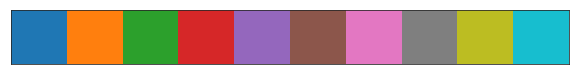

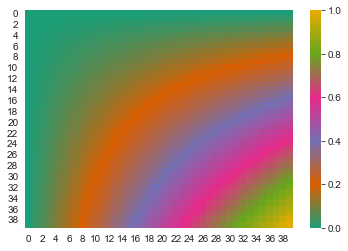

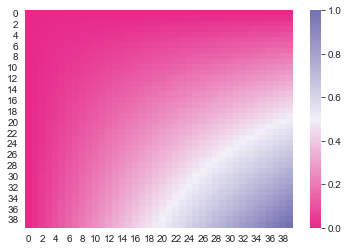

In [2]:
def getRGB(c):
    c = c.lstrip('#') 
    return tuple(int(c[i:i+2], 16) for i in (0, 2, 4))

def getContiniousColormap(colors):
       
    colors = [(e[0] / 255.0, e[1] / 255.0, e[2] / 255.0) for e in colors] 

    nc = len(colors)
    c = np.zeros((3, nc, 3))
    rgb = ['red', 'green', 'blue']
    for idx, e in enumerate(colors):
        for ii in range(3):
            c[ii, idx, :] = [float(idx) / float(nc - 1), e[ii], e[ii]]

    cdict = dict(zip(rgb, c))
    cmap = LinearSegmentedColormap('flatui', cdict) 
    return cmap 


sns.set_style("white")
flatui = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
shades = ['#e7298a', '#f1f0f7', '#7570b3']  
flatui_rgb = [getRGB(c) for c in flatui]
shades_rgb = [getRGB(c) for c in shades] 

discrete_cmap = ListedColormap(flatui)  
sns.palplot(sns.color_palette())  
plt.show() 

cmap_all = getContiniousColormap(flatui_rgb) 
sns.heatmap(np.outer(np.linspace(0, 1, 40), np.linspace(0, 1, 40)), cmap=cmap_all)
plt.show()

cmap = getContiniousColormap(shades_rgb) 
sns.heatmap(np.outer(np.linspace(0, 1, 40), np.linspace(0, 1, 40)), cmap=cmap)
plt.show()

In [3]:
weeks = ["Podatki o prometu v Ljubljani 9 - 11 september 2020", "Podatki o prometu v Ljubljani 5 oktober - 8 november 2020"]  
data_path = os.path.join(".", "data", "google")   

df = pd.DataFrame() 
for week in weeks: 
    csv_file = os.path.join(data_path, week+".csv")
    df_file = pd.read_csv(csv_file, sep=",", skiprows=1) 
    df = df.append(df_file, sort=False, ignore_index=True) 

In [4]:
df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.round("10min") 
df["date"] = df["timestamp"].dt.date     
df['time'] = pd.DatetimeIndex(df['timestamp']).hour + pd.DatetimeIndex(df['timestamp']).minute/60
df["hour"] = df["timestamp"].dt.hour   
df["weekday"] = df["timestamp"].dt.weekday
df["workday"] = df["weekday"].map(lambda x: 1 if x < 5 else 0)
df["speed"] = df["t_distance_[m]"]/df["t_duration_in_traffic_[s]"]
df["pace"] = 1/df["speed"]


filter_dates = True

if filter_dates:   
    date1 =  datetime.date(2020,10,5)  
    date2 = datetime.date(2020,11,8)  

    dates_to_remove_string = ["2020-10-19", "2020-10-23", "2020-10-24", "2020-10-31"]
    dates_to_remove = []
    
    for date_string in dates_to_remove_string:
        dates_to_remove.append(datetime.datetime.strptime(date_string, "%Y-%m-%d").date)   
        
else:
    date1 = None
    date2 = None
    dates_to_remove = []


if date1 is not None:  
    df = df[df['date']>=date1]  
            
if date2 is not None:      
    df = df[df['date']<=date2] 

for dtr in dates_to_remove:
    df = df[df['date'] != dtr]  
               

print(df["timestamp"].min())  
print(df["timestamp"].max()) 

#from 5. 10 to 8. 11 



2020-10-05 00:00:00
2020-11-08 23:20:00


In [5]:
use_external_weather = False  
if not use_external_weather:
    weather = {'clear sky': 'dry', 
           'broken clouds': 'dry',
           'scattered clouds': 'dry', 
           'few clouds': 'dry',
           'moderate rain': 'wet',
           'light rain': 'humid',
           'heavy intensity rain': 'wet',
           'overcast clouds': 'humid', 
           'heavy intensity shower rain': 'wet',
           np.nan: '',
           'shower rain': 'wet',
           'light intensity shower rain': 'wet',
           'fog': 'humid', 
           'mist': 'humid',
           'light intensity drizzle': 'humid', 
           'drizzle': 'humid',
           'heavy intensity drizzle': 'wet'}
    df['weather'] = df["w_description"].map(lambda x: weather[x])
    
    for date in df['date'].unique():
        locs = date == df['date']

        avg_weather = df.loc[locs, 'weather'].mode()[0] # the most frequent entry in a given day
        avg_t = np.nanmean(df.loc[locs, 'w_temperature'])

        df.loc[locs, "avg daily weather"] = avg_weather
        df.loc[locs, "avg daily temp"] = avg_t

        weather = "good" if (avg_weather == 'dry' and avg_t >= 5) or (avg_weather == 'humid' and avg_t >= 10) else 'bad'

        df.loc[locs, "weather"] = weather
else:
    df_weather = pd.read_csv('data\\weather.csv')
    df_weather['date'] = pd.to_datetime(df_weather['date']).dt.date
    for date in df['date'].unique():
        weather = df_weather.loc[df_weather['date'] == date, 'weather'].iloc[0]
        locs = date == df['date']
        df.loc[locs, "weather"] = weather 
        

df["w_description"] = df["w_description"].astype('category')
df["w_description"] = df["w_description"].cat.codes 

#df["weather"] = df["weather"].astype('category')
#df["weather"] = df["weather"].cat.codes   

df["avg daily weather"] = df["avg daily weather"].astype('category')
df["avg daily weather"] = df["avg daily weather"].cat.codes     

print(df)   
        

       Unnamed: 0           timestamp  route_id  t_duration_in_traffic_[s]  \
1878           18 2020-10-05 00:00:00         0                      768.0   
1879           19 2020-10-05 00:00:00         1                      462.0   
1880           20 2020-10-05 00:00:00         2                      508.0   
1881           21 2020-10-05 00:00:00         3                      430.0   
1882           22 2020-10-05 00:00:00         4                      503.0   
1883           23 2020-10-05 00:00:00         5                      649.0   
1884           24 2020-10-05 00:10:00         0                      763.0   
1885           25 2020-10-05 00:10:00         1                      471.0   
1886           26 2020-10-05 00:10:00         2                      497.0   
1887           27 2020-10-05 00:10:00         3                      430.0   
1888           28 2020-10-05 00:10:00         4                      501.0   
1889           29 2020-10-05 00:10:00         5                 

In [6]:
dfs_routes = {}    

cor_df = df[['route_id', 't_duration_in_traffic_[s]', 't_duration_[s]', 'pace', 'speed', 'hour', 'time', 'weekday', 'workday', 'avg daily weather', 'avg daily temp', 'weather']].copy()
cor_df = cor_df.dropna()   

column_names = {'route_id':'Route', 't_duration_in_traffic_[s]': 'Duration in traffic', 't_duration_[s]': 'Duration', 'pace': 'Pace', 'speed': 'Speed', 'hour': 'Hour', 'time': 'Time', 'weekday': 'Weekday', 'workday': 'Workday', 'avg daily weather': 'Daily weather', 'avg daily temp': 'Daily temperature', 'weather': 'Weather'}
routes = cor_df['route_id'].unique()    

for route in routes:  
    df_route = cor_df[cor_df['route_id'] == route].copy()    
    df_route_workday = df_route[df_route["workday"] == 1].copy()
    df_route_weekend = df_route[df_route["workday"] == 0].copy() 
    df_weather_good = df_route[df_route["weather"] == "good"].copy() 
    df_weather_bad = df_route[df_route["weather"] == "bad"].copy() 
    
    dfs = [df_route, df_route_workday, df_route_weekend, df_weather_good, df_weather_bad] 
    
    for i, df_item in enumerate(dfs):
        dfs[i] = df_item.drop(columns=["route_id", "workday", "weather"])     
    
    dfs_routes[route] = dfs        

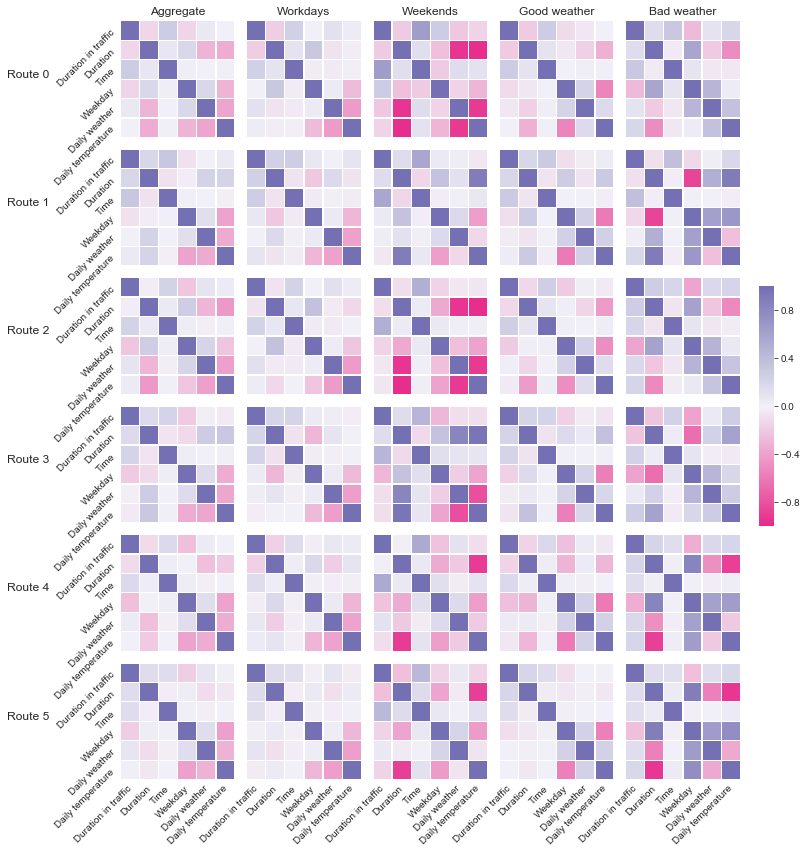

In [7]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, axs = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(750*px, 800*px)) 
fig.tight_layout(rect=[0, 0, .9, 1])  
cbar_ax = fig.add_axes([.901, .35, .02, .3]) 
plt.subplots_adjust(wspace=0.1, hspace=0.1)  

for route_id, df_route_list in dfs_routes.items():     
    for i, df_route in enumerate(df_route_list): 
        df_route = df_route.copy()
        df_route = df_route.drop(columns=["speed", "hour", "pace"])         
        
        data_as_array = df_route.values 
        axes = axs[route_id, i]

        partial_corr_array = partial_corr(np.hstack((np.ones((data_as_array.shape[0],1)), data_as_array)))[1:,1:]
        df_route = pd.DataFrame(partial_corr_array, columns = [column_names[x] for x in df_route.columns])   
        df_route.rename(index = {k: v for k, v in enumerate(df_route.columns)}, inplace=True)
        
        sns.heatmap(df_route, linewidths=.25, cbar=route_id==0, cbar_ax=None if route_id else cbar_ax, ax=axes, cmap=cmap, vmin=-1, vmax=1)     
        axes.tick_params(left=False, bottom=False)  
        plt.sca(axes)
        plt.xticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', verticalalignment='center')   
        plt.yticks(rotation=45, rotation_mode='anchor', horizontalalignment='right', verticalalignment='center')   

cols = ["Aggregate", "Workdays", "Weekends", "Good weather", "Bad weather"]  
rows = ["Route " + str(i) for i in dfs_routes.keys()] 
        
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')  
    ax.yaxis.set_label_coords(-.8, .5)  
        
plt.savefig(os.path.join("figs", "partial_correlation.png"), bbox_inches="tight")         
plt.savefig(os.path.join("figs", "partial_correlation.pdf"), bbox_inches="tight") 
plt.show()  

Route 0


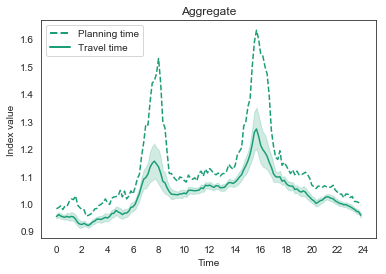

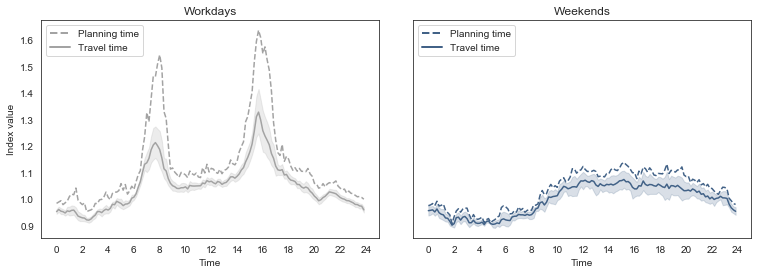

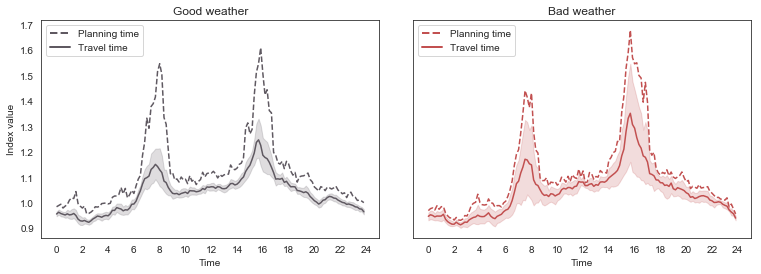

Route 1


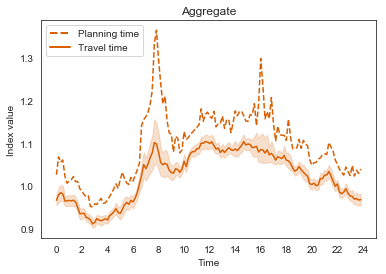

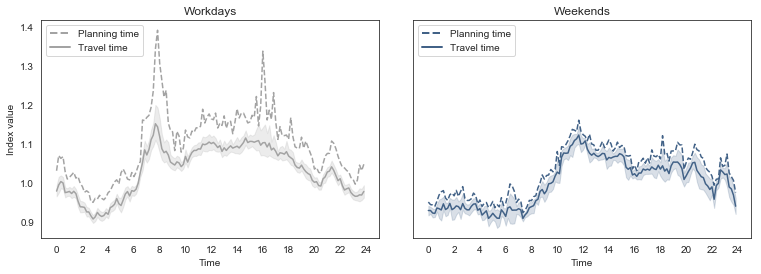

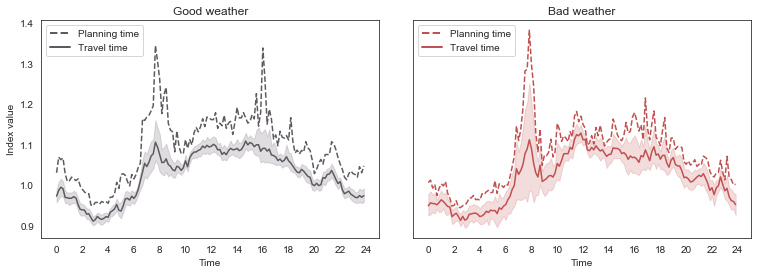

Route 2


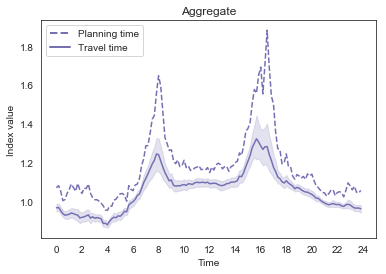

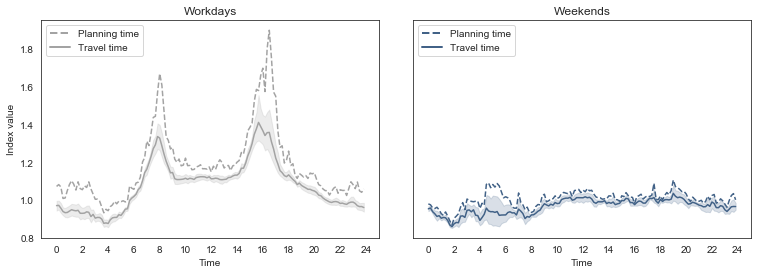

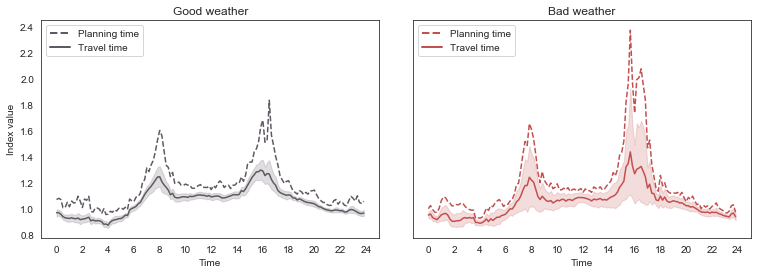

Route 3


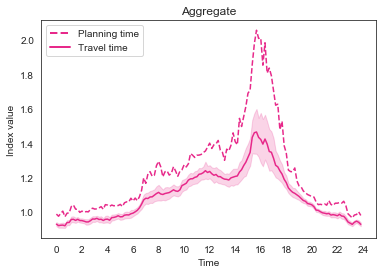

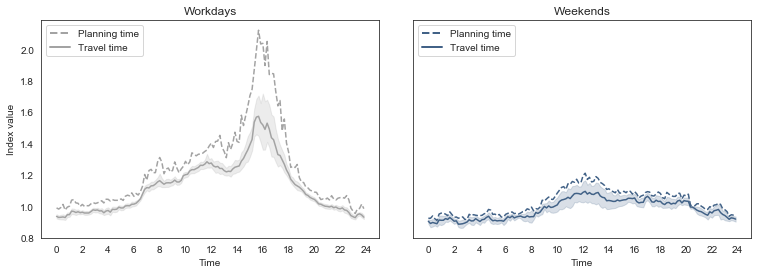

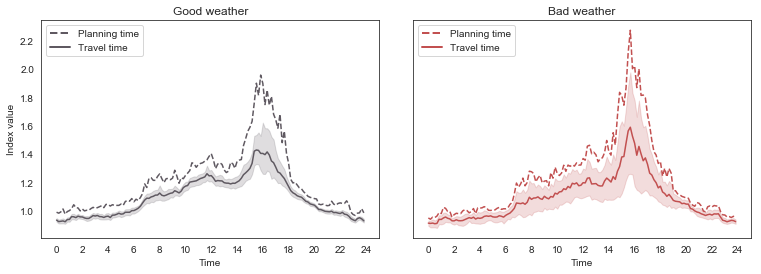

Route 4


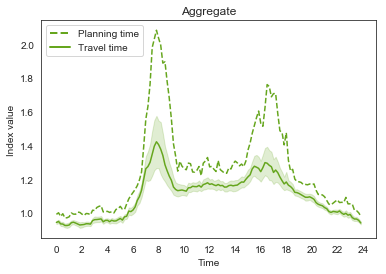

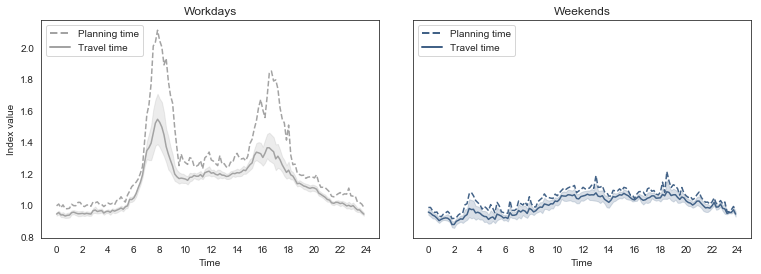

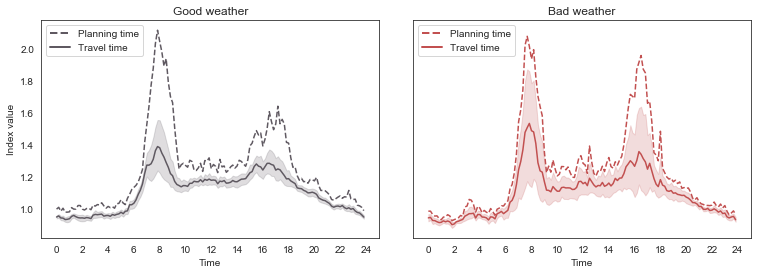

Route 5


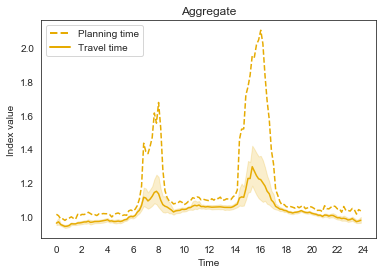

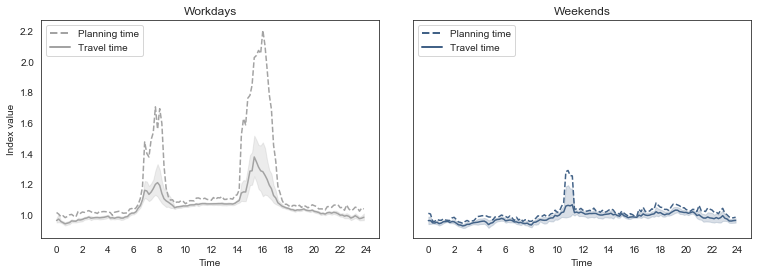

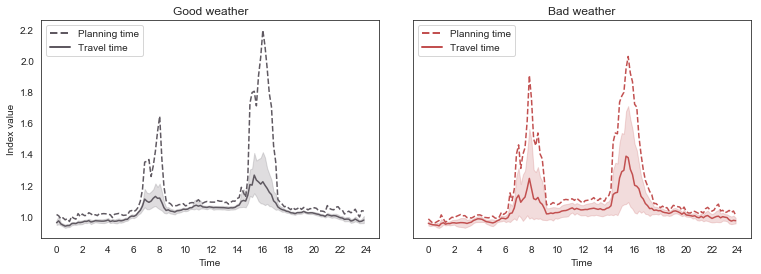

In [8]:
for route_id, df_route_list in dfs_routes.items(): 
    
    print("Route " + str(route_id)) 
    
    #get freeflow for every route 
    df_aggregate = df_route_list[0]  
    
    ndf = df_aggregate[["time", "t_duration_in_traffic_[s]"]].copy()   
    ndf = ndf[(ndf["time"] >= 22) | (ndf["time"] <= 5)].copy() # 10pm to 5am  
    freeflow85 = ndf["t_duration_in_traffic_[s]"].quantile(0.85)    
    
    route_color = False 
    weather_workday = True 
    
    if route_color:
        sns.set_palette(flatui) 
    
    titles = ["Aggregate", "Workdays", "Weekends", "Good weather", "Bad weather"]   
    for i, df_route in enumerate(df_route_list):   

        ttbytime = df_route.groupby(df_route['time']).mean().reset_index()  
        #print(ttbytime)             
        
        df_route["travel_time_index"] = df_route["t_duration_in_traffic_[s]"]/freeflow85     
        ttbytime["tt95"] = df_route.groupby(df_route['time'])["t_duration_in_traffic_[s]"].quantile(0.95).reset_index()["t_duration_in_traffic_[s]"]
        ttbytime["buffer_index"] = (ttbytime["tt95"] - ttbytime['t_duration_in_traffic_[s]'])/ttbytime['t_duration_in_traffic_[s]'] 
        ttbytime["planning_time_index"] = ttbytime["tt95"]/freeflow85  
        ttbytime["travel_time_index"] = ttbytime["t_duration_in_traffic_[s]"]/freeflow85   

        axes = None
        if i == 0:
            fig = plt.gcf()  
            size = fig.get_size_inches() 
        else:
            if i == 1 or i == 3: 
                fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(size[0]*2.12, size[1]))     
                plt.subplots_adjust(wspace=0.1, hspace=0.1)       
            axes = axs[(i - 1)%2]    
    
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))        
        #ax = sns.lineplot(data=ttbytime, x="time", y="travel_time_index", ax = axes) 
        
        title_color=""
        if route_color: 
            #encoded by route color
            ax = sns.lineplot(data=ttbytime, x="time", y="planning_time_index",  ax = axes, color=discrete_cmap(route_id))         
            ax = sns.lineplot(data=df_route, x="time", y="travel_time_index", ax = axes, color=discrete_cmap(route_id))     
            ax.lines[0].set_linestyle("--")  
        
            custom_lines = [Line2D([0], [0], color=discrete_cmap(route_id), linestyle="--", lw=2), Line2D([0], [0], color=discrete_cmap(route_id), lw=2)] 
            ax.legend(custom_lines, ['Planning time', "Travel time"], loc='upper left')          
        elif weather_workday: 
            plt_clr = discrete_cmap(route_id)   
            if titles[i] == "Workdays":
                plt_clr = "#a3a3a3"
            elif titles[i] == "Weekends":
                plt_clr = "#426287" 
            elif titles[i] == "Good weather":
                plt_clr = "#5f5961"
            elif titles[i] == "Bad weather":
                plt_clr = "#c25050"   
                
                
            title_color="workday_weather_encoded"  
            ax = sns.lineplot(data=ttbytime, x="time", y="planning_time_index",  ax = axes, color=plt_clr)         
            ax = sns.lineplot(data=df_route, x="time", y="travel_time_index", ax = axes, color=plt_clr)     
            ax.lines[0].set_linestyle("--")  
        
            custom_lines = [Line2D([0], [0], color=plt_clr, linestyle="--", lw=2), Line2D([0], [0], color=plt_clr, lw=2)]   
            ax.legend(custom_lines, ['Planning time', "Travel time"], loc='upper left')              
        else:
            #orange blue encoding
            cmap = plt.cm.tab10
            title_color="orange_blue"
            ax = sns.lineplot(data=ttbytime, x="time", y="planning_time_index",  ax = axes)           
            ax =sns.lineplot(data=df_route, x="time", y="travel_time_index", ax = axes)       
        
            custom_lines = [Line2D([0], [0], color=cmap(0), lw=2), Line2D([0], [0], color=cmap(1), lw=2)]     
            ax.legend(custom_lines, ['Planning time', "Travel time"], loc='upper left')        
            
        
        ax.set(xlabel='Time', ylabel='Index value')  
        ax.set_title(titles[i])  
                
        if i % 2 == 0:    
            plt.savefig(os.path.join("figs", "Route_" + str(route_id) + "_" + titles[i] + title_color + ".png"), bbox_inches="tight")
            plt.savefig(os.path.join("figs", "Route_" + str(route_id) + "_" + titles[i] + title_color + ".pdf"), bbox_inches="tight")   
            plt.show()              
    
    